In [2]:
% matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import itertools
import time

In [3]:
class Color_world:
    # creates a randomized color world! This is a world of xsize x ysize 
    # pixels. Each pixel has *two* quantity values between 0 and 1. 
    # The first quantity q1 is initiallized randomly. The second, q2, is determined
    # by the average of the q1 values of neighboring pixels, where each
    # pixel 3 (corners), 5(sides), or 8 neighbors.
    
    def __init__(self):
        pass
        
    def initialize_random(self,xsize,ysize):
        self.xsize = xsize
        self.ysize = ysize
        self.world = np.zeros((xsize,ysize,2))
        self.world[:,:,0] = np.random.random((xsize,ysize))
        self.pixel_law()
    
    def initialize(self,world):
        self.world = world
        self.xsize = len(world)  # the width of 
        self.ysize = len(world[0])
        self.pixel_law()
        
    def pixel_law(self):
        for i, row in enumerate(self.world):
            for j, pixel in enumerate(row):
#                 pixel[1] = 1
                pixel[1] = mean_neighbors(i,j,self.world)

    def draw(self):
        q1 = [[el[0] for el in row] for row in self.world]
        q2 = [[el[1] for el in row] for row in self.world]

        plt.figure(1)
        plt.subplot(211)
        plt.title('World q1:')
        plt.axis('off')
        plt.imshow(q1)
        
        plt.subplot(212)
        plt.title('World q2:')
        plt.axis('off')
        plt.imshow(q2)
        
        plt.subplots_adjust(hspace=0.5)
        
        plt.show()  

In [22]:
# A bunch of global functions here.

def mean_neighbors(i,j,f):
    # return mean of q1 in neighbors around i,j in f
    total,cells = 0,0
    maxx = len(f)-1
    maxy = len(f[0])-1
    for x in (i-1,i,i+1):
        for y in (j-1,j,j+1):
            if not (x>maxx or y>maxy) and not (x<0 or y<0) and not (x==i and y == j):
                total += f[x][y][0]
                cells += 1
    return total/cells

def shuffler(w):
    # takes a world, returns a randomly shuffled array of pixels
    shuffled = []
    for row in w:
        for el in row:
            shuffled.append(el)
    np.random.shuffle(shuffled)
    return shuffled

def reconstruct(w):
    # the business! given a pixel array, it finds all the possible neighborhoods
    #, then for each pixel, finds the neighborhood that satisfies pixel_law
    # It returns a list of [pixel, neighborhood] pairs.
    
    start = time.time()
    neighborhoods = []
    corner_nhoods = list(itertools.combinations(w,3))
    side_nhoods = list(itertools.combinations(w,5))
    middle_nhoods = list(itertools.combinations(w,8))
    nhoods = [corner_nhoods,side_nhoods,middle_nhoods]
    for i, el in enumerate(w):
        # go through the pixels of w, and find the correct nhood
        el_nhood = find_nhood(el,nhoods) # None if the nhood isn't a match
        neighborhoods.append([el,el_nhood])
    end = time.time()
    print 'reconstructing took %s seconds' %(end-start)
    return neighborhoods
    
def find_nhood(el, nhoods):
    # given a pixel, checks the 3,5 and 8-membered neighborhoods
    corners, sides, middles = nhoods
    try_corner = check_nhoods(el,corners)
    if try_corner:
        return try_corner
    try_side = check_nhoods(el,sides)
    if try_side:
        return try_side
    try_middle = check_nhoods(el,middles)
    if try_middle:
        return try_middle
    return None

def mean_q1(nhood):
    # given a group of pixels, returns mean q1
    mean = 0
    for el in nhood:
        mean += el[0]
    return mean/len(nhood)

def check_nhoods(el,neighborhoods):
    # this function takes a pixel and a list of neighborhoods, then returns 
    # the nhood that satisfies pixel_law
    for n in neighborhoods:
        if round(el[1],10) == round(mean_q1(n),10): #ok the rounding is weird. Apparently np.random.shuffle creates some kind of rounding error??
            return n

class Puzzle:
    # given a list of [pixel,neighborhood] pairs, reconstructs a consistent
    # arrangement. A feature, not a bug: it's blind to symmetries of rotation/
    # reflection.
    
    # strategy: randomly fill one corner, fill one side, then the other side, then move to (1,1) and repeat
    # not the most elegant algorithm.
    
    def __init__(self, nhoods):
        self.nhoods = nhoods
        self.grid = [[]]
        self.corners = [el for el in self.nhoods if len(el[1]) == 3]
        self.sides = [el for el in self.nhoods if len(el[1]) == 5]
        self.filling = [el for el in self.nhoods if len(el[1]) == 8]
        print 'corners: %s' %len(self.corners)
        print 'sides: %s' %len(self.sides)
        print 'filling: %s' %len(self.filling)
        self.x = 0
        self.y = 0
        self.used = []
        self.rows = 0
        self.columns = 0
        self.grid[0].append(self.corners[0])
        self.used.append(self.corners[0][0])
        
    def fill_xside(self):
        # it's
        while self.x==0:
            self.add_xside()
    
    def fill_yside(self):
        while self.y==0:
            self.add_yside()
        
    def add_xside(self):
        x,y = self.x, self.y #the last added square
        leftbound = self.grid[x][y] #the element to the left
        otherside = self.grid[x][y-1]
        if otherside == leftbound:
            otherside = []
        visible_corner = [c for c in self.corners if c[0] in leftbound[1] and c[0] not in self.used]
        if visible_corner:
            vc = visible_corner[0]
            self.grid[x].append(visible_corner[0])
            self.rows = self.y
            self.x += 1
            self.y = 0
        else:
            side_candidates = [s for s in self.sides if s[0] in leftbound[1] and s[0] not in self.used]
            if otherside:
                side_candidates = [s for s in side_candidates if s[0] not in otherside[1]]
            self.grid[x].append(side_candidates[0])
            self.used.append(side_candidates[0][0])
            self.y += 1
                
    def add_yside(self):
        x,y = self.x, self.y #where to start
        leftbound = self.grid[x][y] #the element to the left
        otherside = self.grid[x-1][y]
        if otherside == leftbound:
            otherside = []
        visible_corner = [c for c in self.corners if c[0] in leftbound[1] and c[0] not in self.used]
        if visible_corner:
            vc = visible_corner[0]
            self.grid.append([visible_corner[0]])
            self.columns = self.x
            self.y += 1
            self.x = 0
        else:
            side_candidates = [s for s in self.sides if s[0] in leftbound[1] and s[0] not in self.used]
            if otherside:
                side_candidates = [s for s in side_candidates if s[0] not in otherside[1]]

            self.grid.append([side_candidates[0]])
            self.used.append(side_candidates[0][0])
            self.x += 1

    def fill(self):
        for column in range(1,self.columns+2):
            for row in range(1,self.rows+2):
                #start with (1,1)
                target = [column,row]  #?
                n1 = self.grid[column-1][row-1][1]
                n2 = self.grid[column][row-1][1]
                n3 = self.grid[column-1][row][1]
                newbox = [box for box in self.nhoods if box[0] in n1 and box[0] in n2 and box[0] in n3]
                self.grid[column].append(newbox[0])
    
    def solve(self):
        self.fill_xside()
        self.x = 0
        self.y = 0
        self.fill_yside()
        self.fill()

def listify(nhoods):
    # turns our ndarrays into simple lists, for easy working
    list_nhoods = []
    for group in nhoods:
        pq1,pq2 = group[0]
        pixel = [pq1,pq2]
        nhood = [[float(el[0]),float(el[1])] for el in group[1]]
        list_nhoods.append([pixel,nhood])
    return list_nhoods        
        
def format_grid(grid):
    # removes neighborhoods
    new_grid = []
    for row in grid:
        nrow = []
        for el in row:
            nrow.append(el[0])
        new_grid.append(nrow)
    return new_grid

def rebuild_world(neighborhoods):
    # takes a list of neighborhoods, creates a Puzzle instance, solves it, returns arranged grid.
    puzzle = Puzzle(neighborhoods)
    puzzle.solve()
    return puzzle.grid

def draw(world):
    # gotta see things
    q1 = [[el[0] for el in row] for row in world]
    q2 = [[el[1] for el in row] for row in world]

    plt.figure(1)
    plt.subplot(211)
    plt.title('World q1:')
    plt.axis('off')
    plt.imshow(q1)

    plt.subplot(212)
    plt.title('World q2:')
    plt.axis('off')
    plt.imshow(q2)

    plt.subplots_adjust(hspace=0.5)

    plt.show()

In [13]:
world = Color_world() # random starting point

In [14]:
world.initialize_random(5,5)

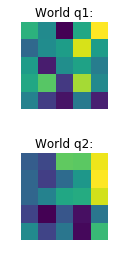

In [15]:
world.draw() # here are the arrangements of quantities

In [23]:
world.shuffled = shuffler(world.world) # randomize!

In [17]:
world.reconstructed = reconstruct(world.shuffled) # returns the correct neighborhood structure

reconstructing took 26.7097418308 seconds


In [41]:
# use the neighborhood structure to rearrange the randomize pixels
world.puzzle = format_grid(rebuild_world(listify(world.reconstructed))) 

corners: 4
sides: 12
filling: 9


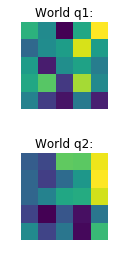

In [19]:
# As a reminder: here's what we started with:
world.draw()

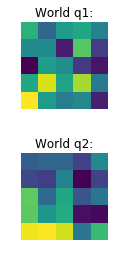

In [20]:
# Here's our reconstructed world: (since the laws don't care about rotations or reflections, 
# these might be simple transformations of the starting point.)
draw(world.puzzle)

In [104]:
# I thought it might be possible to speed this up by using a generator instead of creating a
# list of neighborhoods.
    #     - generate nhoods as we go, instead of generating all first then checking them
    #     - assume there will be a unique correct nhood, so stop as soon as one is found.

# It's a little faster: ~20s vs ~26s

def try_nhoods2(w,el,n):
    # take all n-membered hoods in w, check if it satisfies the law
    nhooditer = (itertools.combinations(w,n))
    target = round(el[1],10) 
    for nhood in nhooditer:
        attempt = round(mean_q1(nhood),10)
        if target == attempt:
            print 'found: %s == %s' %(target, attempt)
            return nhood
    return None
        
def reconstruct2(w):
    start = time.time()
    neighborhoods = []
    for el in w:
        neighborhoods.append([el,find_nhood2(w,el)])
    end = time.time()
    print 'reconstructing took %s seconds' %(end-start)
    return neighborhoods
    
def find_nhood2(w,el):
    try_corner2 = try_nhoods2(w,el,3)
    if try_corner2:
        return try_corner2
    try_side2 = try_nhoods2(w,el,5)
    if try_side2:
        return try_side2
    try_middle2 = try_nhoods2(w,el,8)
    if try_middle2:
        return try_middle2

In [105]:
generator_version = reconstruct2(world.shuffled)

found: 0.7514393447 == 0.7514393447
found: 0.5507120411 == 0.5507120411
found: 0.4738690995 == 0.4738690995
found: 0.6109494281 == 0.6109494281
found: 0.5859566804 == 0.5859566804
found: 0.5580909225 == 0.5580909225
found: 0.5323242236 == 0.5323242236
found: 0.5268823297 == 0.5268823297
found: 0.6673723128 == 0.6673723128
found: 0.5313900218 == 0.5313900218
found: 0.6493864228 == 0.6493864228
found: 0.6872761155 == 0.6872761155
found: 0.5675370834 == 0.5675370834
found: 0.5999172642 == 0.5999172642
found: 0.536261048 == 0.536261048
found: 0.6434679754 == 0.6434679754
found: 0.7592144963 == 0.7592144963
found: 0.4850405204 == 0.4850405204
found: 0.5739303299 == 0.5739303299
found: 0.5864230033 == 0.5864230033
found: 0.4795891804 == 0.4795891804
found: 0.5675439024 == 0.5675439024
found: 0.6251080881 == 0.6251080881
found: 0.6890652411 == 0.6890652411
found: 0.7397009606 == 0.7397009606
reconstructing took 26.0954191685 seconds
